# Exporting American Movie Box Office Hits 

### Regresssion Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [Scraped: Movie Adaptations Data](#2) <br/>
3. [Exporatory Data Analysis: Movie Adaptations Dataframe](#3)<br/>
   [3a. Explore features correlation](#3a)<br/>
   [3b. Explore and handle categorical data](#3b)<br/>
4. [Cross-Validation](#4)<br/>
5. [Modeling](#5)<br/>
6. [Model Tuning](#6) <br/>
   [6a. Regularization](#6a)<br/>
   [6b. Features engineering](#6b)<br/>
   [6c. Modeling with new features](#6c)<br/> 
   [6d. Linear regression assumptions](#6d)<br/>
7. [Best Model ](#7)<br/>
8. [Results](#8)<br/>
   [8a. Interpretability](#8a)<br/>
   [8b. Predictions](#8b)<br/>

In [1]:
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as py
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats



In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error
%matplotlib inline


## 1. Research Question<a id='1'></a> 

* RQ. Can a model predict a movie adaptaion <sup>1</sup> international total gross revenue based on movie data available on boxofficemojo.com?
* Data source: boxofficemojo.com 
* Error metric: mean_squared_error

<sup>1</sup> Adapted from books, television shows, events, video games, or plays. 


## 2. Scraped [Movie Adaptations Data](https://github.com/slp22/regression-project/blob/main/adaptation_movies_webscraping.ipynb) 


## 3. Exporatory Data Analysis: [Movie Adaptations Dataframe](https://github.com/slp22/regression-project/blob/main/adaptation_movies_eda.ipynb) 

In [3]:
movie_df = pd.read_csv('clean_df.csv')
movie_df.drop(columns=['link_stub'], inplace=True)
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG


In [ ]:
movie_df.describe()

In [ ]:
# check for null values
movie_df.isnull().sum()

In [4]:
# drop null values
movie_df.dropna(axis=0, how='any', inplace=True)

In [ ]:
# double check for null values
movie_df.isnull().sum()

In [ ]:
movie_df.info()

### 3a. Explore features correlation<a id='3a'></a> 

In [ ]:
# sns.pairplot(movie_df, height=5, aspect=1.5);

In [ ]:
# heatmap correlation matrix
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

### Correlation Summary

#### Target-Features
*target = `international_total_gross`*
* target correlated with (highest to lowest):
    * `domestic_total_gross`
    * `domestic_opening`
    * `budget`
    * `max_theaters`
    * `opening_theathers`

Target is highly correlated with `worldwide_total_gross`; has known multicollinearity as:<br/>
`worldwide_total_gross` = `domestic_total_gross` + `international_total_gross`

####  Features-Features: Positive Correlation
* domestic_total_gross:
    * `domestic_opening`
    * `worldwide_total_gross`
    * `budget`
    * `max_theaters`
    * `opening_theathers`
* domestic_opening:<br/>
    * `budget`
    * `max_theaters`
    * `opening_theathers`
* max_theaters:
    * `opening_theathers`
    * `budget`
    * `domestic_opening`

####  Features-Features: Negative Correlation
* rank:
    * `domestic_total_gross`
    * `max_theaters`
    * `opening_theathers`
    * `domestic_opening`
    * `budget`
    


### 3b. Explore and handle categorical data<a id='3b'></a> 

In [ ]:
# explore genres as candidate for dummies
print('Unique genres:', movie_df.genres.nunique())
print('\n')
print('Genres counts\n', movie_df['genres'].value_counts())
# 👎 too many; look for other dummy variables. 

In [5]:
# explore MPAA rating as candidate for dummies
print('Unique MPAA ratings:', movie_df.rating.nunique())
print('\n')
rating_count = movie_df['rating'].value_counts()
print('Rating counts\n', rating_count)
# 👍 easy-to-use for dummy variables

Unique MPAA ratings: 4


Rating counts
 PG13    304
R       217
PG      189
G         8
Name: rating, dtype: int64


In [6]:
# get dummies for MPAA rating 
df_dummies_rating = pd.get_dummies(movie_df, columns=['rating'], drop_first=True)
df_dummies_rating.head(2)
movie_df = df_dummies_rating
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating_PG,rating_PG13,rating_R
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,1,0,0


In [7]:
# explore distributor as candidate for dummies 
print('Unique distributors:', movie_df.distributor.nunique())
print('\n')
distributor_count = movie_df['distributor'].value_counts()
print('Distributor count\n', distributor_count)
# 👍 Reasonable amount, group lower frequencies into an other category.

Unique distributors: 66


Distributor count
 Warner Bros.                           123
Twentieth Century Fox                   89
Paramount Pictures                      88
Walt Disney Studios Motion Pictures     73
Universal Pictures                      68
                                      ... 
Fox Atomic                               1
United Artists Releasing                 1
Pantelion Films                          1
TriStar Pictures                         1
Cinedigm Entertainment Group             1
Name: distributor, Length: 66, dtype: int64


In [8]:
# create distributor other category
distributor_other = list(distributor_count[distributor_count < 20].index)
movie_df['distributor'] = movie_df['distributor'].replace(distributor_other, 'other')

# get dummies for distributor
df_dummies_distributor = pd.get_dummies(movie_df, columns=['distributor'], drop_first=True)
movie_df = df_dummies_distributor
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,...,rating_PG,rating_PG13,rating_R,distributor_Paramount Pictures,distributor_Sony Pictures Entertainment (SPE),distributor_Twentieth Century Fox,distributor_Universal Pictures,distributor_Walt Disney Studios Motion Pictures,distributor_Warner Bros.,distributor_other
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
movie_df.columns

[back to top](#top)

## 4. Cross-Validation<a id='4'></a> 

In [9]:
# separate target from select features
y = movie_df['international_total_gross']
X = movie_df.loc[:,['domestic_total_gross', 
                    'domestic_opening', 
                    'budget',
                    'max_theaters', 
                    'opening_theathers',
                    'rank',
                    'runtime',
                    'release_date',
                    'rating_PG', 
                    'rating_PG13',
                    'rating_R',
                    'distributor_Paramount Pictures',
                    'distributor_Sony Pictures Entertainment (SPE)',
                    'distributor_Twentieth Century Fox', 
                    'distributor_Universal Pictures',
                    'distributor_Walt Disney Studios Motion Pictures',
                    'distributor_Warner Bros.', 
                    'distributor_other']]

In [10]:
# split test data set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [11]:
# set up k-folds 
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state = 42)

[back to top](#top)

## 5. Modeling<a id='5'></a> 

In [88]:
# simple linear regression
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y_train, cv=kfold)
print('k-fold indivdual scores:', scores)
print('linear regression k-fold mean score:', np.mean(scores))

lin_reg.fit(X_train, y_train)

k-fold indivdual scores: [0.7486569  0.757162   0.86214297 0.72927468 0.74714238]
linear regression k-fold mean score: 0.7688757853732312


LinearRegression()

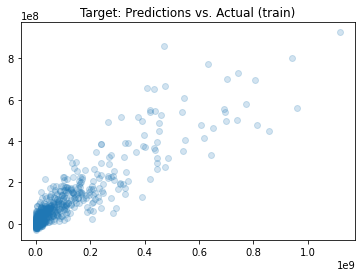

In [17]:
# train: fitted vs. actual
y_train_predict = lin_reg.predict(X_train)

plt.scatter(y_train, y_train_predict, alpha=0.2)
plt.plot([0, 400], [0, 400])
plt.title("Target: Predictions vs. Actual (train)");

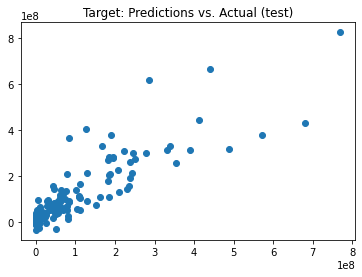

In [18]:
# test: fitted vs. actual
y_test_predict = lin_reg.predict(X_test)

plt.scatter(y_test, y_test_predict)
plt.plot([0, 400], [0, 400])
plt.title('Target: Predictions vs. Actual (test)');

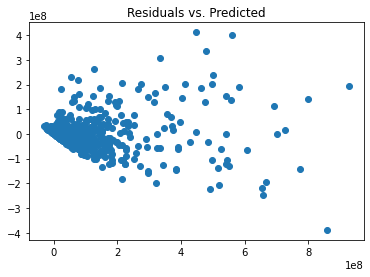

In [19]:
# residuals vs. predicted
lin_reg_residuals = y_train - y_train_predict

plt.scatter(y_train_predict, lin_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predicted");

## 6. Model Tuning<a id='6'></a> 

In [20]:
# standard-scaling features before regularization 
std = StandardScaler()
std.fit(X_train.values)

# apply scaler to train data
X_train_std = std.transform(X_train)

# apply scaler to test data
X_test_std = std.transform(X_test)

/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### 6a. Regularization<a id='6a'></a> 

In [89]:
# lasso model
lasso_model = Lasso(alpha = 1000)
lasso_model.fit(X_train_std, y_train)

Lasso(alpha=1000)

In [90]:
list(zip(X_train.columns, lasso_model.coef_))

[('domestic_total_gross', 129376296.98786846),
 ('domestic_opening', 10039496.739888232),
 ('budget', 23276475.99760897),
 ('max_theaters', 9768654.51751922),
 ('opening_theathers', -7374879.242003454),
 ('rank', 24365539.347494036),
 ('runtime', 10475111.89636021),
 ('release_date', 11805649.570314046),
 ('rating_PG', 19504275.385536455),
 ('rating_PG13', 18953751.73729921),
 ('rating_R', 18506966.520896453),
 ('distributor_Paramount Pictures', 2563439.7493831697),
 ('distributor_Sony Pictures Entertainment (SPE)', 3946701.271349205),
 ('distributor_Twentieth Century Fox', 7771145.865045143),
 ('distributor_Universal Pictures', 2419316.9119878192),
 ('distributor_Walt Disney Studios Motion Pictures', 7057401.336859129),
 ('distributor_Warner Bros.', 5351564.513109605),
 ('distributor_other', 3966519.2494462947)]

In [46]:
# ridge model 
ridge_model = Ridge(alpha = 1000)
ridge_model.fit(X_train_std, y_train)

Ridge(alpha=1000)

In [47]:
list(zip(X_train.columns, ridge_model.coef_))

[('domestic_total_gross', 28834397.204676356),
 ('domestic_opening', 26072565.657504786),
 ('budget', 16675896.428669898),
 ('max_theaters', 8320860.114495709),
 ('opening_theathers', 7494900.076725193),
 ('rank', -14136897.839843014),
 ('runtime', 12261042.001032893),
 ('release_date', 6072473.520566338),
 ('rating_PG', -3292.8959808435625),
 ('rating_PG13', 2370165.2666965183),
 ('rating_R', -2042099.0292138327),
 ('distributor_Paramount Pictures', -1472143.0855068136),
 ('distributor_Sony Pictures Entertainment (SPE)', -1002330.8902171563),
 ('distributor_Twentieth Century Fox', 432688.50490794313),
 ('distributor_Universal Pictures', -1545333.0744872333),
 ('distributor_Walt Disney Studios Motion Pictures', 4787040.484648554),
 ('distributor_Warner Bros.', 2160227.0124485344),
 ('distributor_other', -1094099.0523894662)]

In [48]:
# elastic model 
elastic_model = ElasticNet(alpha = 1000, l1_ratio=1)
elastic_model.fit(X_train_std, y_train)

ElasticNet(alpha=1000, l1_ratio=1)

In [49]:
list(zip(X_train.columns, elastic_model.coef_))

[('domestic_total_gross', 129376296.98786846),
 ('domestic_opening', 10039496.739888232),
 ('budget', 23276475.99760897),
 ('max_theaters', 9768654.51751922),
 ('opening_theathers', -7374879.242003454),
 ('rank', 24365539.347494036),
 ('runtime', 10475111.89636021),
 ('release_date', 11805649.570314046),
 ('rating_PG', 19504275.385536455),
 ('rating_PG13', 18953751.73729921),
 ('rating_R', 18506966.520896453),
 ('distributor_Paramount Pictures', 2563439.7493831697),
 ('distributor_Sony Pictures Entertainment (SPE)', 3946701.271349205),
 ('distributor_Twentieth Century Fox', 7771145.865045143),
 ('distributor_Universal Pictures', 2419316.9119878192),
 ('distributor_Walt Disney Studios Motion Pictures', 7057401.336859129),
 ('distributor_Warner Bros.', 5351564.513109605),
 ('distributor_other', 3966519.2494462947)]

In [91]:
y_pred = lin_reg.predict(X_test)
print(f'Linear Regression MAE on test: {mean_absolute_error(y_test, y_pred)}')

y_pred = lasso_model.predict(X_test)
print(f'Lasso Regression MAE on test: {mean_absolute_error(y_test, y_pred)}')

y_pred = ridge_model.predict(X_test)
print(f'Ridge Regression MAE on test: {mean_absolute_error(y_test, y_pred)}')

y_pred = elastic_model.predict(X_test)
print(f'ElasticNet Regression MAE on test: {mean_absolute_error(y_test, y_pred)}')


Linear Regression MAE on test: 45421099.61077295
Lasso Regression MAE on test: 1.2129811269683776e+16
Ridge Regression MAE on test: 3929420110465276.5
ElasticNet Regression MAE on test: 1.2129811269683776e+16


/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


#### Linear Regression best model based on MAE (test): 45421099.61

[back to top](#top)

### 6b. Features engineering<a id='6b'></a> 

In [24]:
# log transformation for monetary columns 

# check for zeros in columns before log transformation 
count = (movie_df['international_total_gross'] == 0).sum()
print('count zeros in international_total_gross:', count)

count = (movie_df['domestic_total_gross'] == 0).sum()
print('count of zeros in domestic_total_gross:', count)

count = (movie_df['budget'] == 0).sum()
print('count of zeros in budget:', count)
# budget: min $0, max $270,000,000
# 👎 zeros throwing division-zero error; will not transform 

count = (movie_df['domestic_opening'] == 0).sum()
print('count of zeros in domestic_opening:', count)
# domestic_opening: min $0, max $191,770,800
# 👎 zeros throwing division-zero error; will not transform 


# 👍 international_total_gross and domestic_total_gross
# international_total_gross: min $98, max $1,119,261,000
movie_df['log_international_total_gross'] = np.log(movie_df['international_total_gross'])

# domestic_total_gross: min $742, max $543,638,043
movie_df['log_domestic_total_gross'] = np.log(movie_df['domestic_total_gross'])


count zeros in international_total_gross: 0
count of zeros in domestic_total_gross: 0
count of zeros in budget: 214
count of zeros in domestic_opening: 1


In [25]:
# profit = domestic_total_gross - budget
movie_df['profit'] = (movie_df['domestic_total_gross'] - movie_df['budget'])

In [26]:
# opening = domestic_opening * opening_theathers
movie_df['opening'] = (movie_df['domestic_opening'] * movie_df['opening_theathers'])

In [27]:
# opening_minus_budget = domestic_opening * budget
movie_df['opening_minus_budget'] = (movie_df['domestic_opening'] - movie_df['budget'])

In [ ]:
movie_df.columns

[back to top](#top)

### 6c. Modeling with new features<a id='6c'></a> 

In [29]:
# separate target from new and original features
y2 = movie_df['international_total_gross']
X2 = movie_df.loc[:,['domestic_total_gross', 
                       'rank', 
                       'max_theaters', 
                       'opening_theathers',
                       'domestic_opening', 
                       'budget', 
                       'release_date',
                       'runtime', 
                       'rating_PG', 
                       'rating_PG13', 
                       'rating_R',
                       'distributor_Paramount Pictures',
                       'distributor_Sony Pictures Entertainment (SPE)',
                       'distributor_Twentieth Century Fox', 
                       'distributor_Universal Pictures',
                       'distributor_Walt Disney Studios Motion Pictures',
                       'distributor_Warner Bros.', 
                       'distributor_other',
                       'log_international_total_gross', 
                       'log_domestic_total_gross', 
                       'profit',
                       'opening', 
                       'opening_minus_budget']]


In [30]:
# split test data set
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                        y2,
                                                        test_size=0.2, 
                                                        random_state=42)


In [31]:
# standard-scaling features before regularization 
std = StandardScaler()
std.fit(X2_train.values)

# apply scaler to train data
X2_train_std = std.transform(X2_train)

# apply scaler to test data
X2_test_std = std.transform(X2_test)

/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [92]:
# lasso model + feature engineering
lasso_model_feat = Lasso(alpha = 1000000)
lasso_model_feat.fit(X2_train_std, y_train)

Lasso(alpha=1000000)

In [93]:
list(zip(X2_train.columns, lasso_model_feat.coef_))

[('domestic_total_gross', 110750241.52231793),
 ('rank', 27606416.490036495),
 ('max_theaters', -1822211.0495561764),
 ('opening_theathers', -4053435.878393262),
 ('domestic_opening', 0.0),
 ('budget', 0.0),
 ('release_date', 7131871.889962489),
 ('runtime', 6505003.834725986),
 ('rating_PG', 2588692.808026557),
 ('rating_PG13', -0.0),
 ('rating_R', -0.0),
 ('distributor_Paramount Pictures', -933949.0562269454),
 ('distributor_Sony Pictures Entertainment (SPE)', -0.0),
 ('distributor_Twentieth Century Fox', 1042971.9519426785),
 ('distributor_Universal Pictures', -857623.6724335651),
 ('distributor_Walt Disney Studios Motion Pictures', 1149865.4008911166),
 ('distributor_Warner Bros.', 879372.905241442),
 ('distributor_other', 0.0),
 ('log_international_total_gross', 42622480.93355351),
 ('log_domestic_total_gross', -9877509.076026358),
 ('profit', 0.0),
 ('opening', 33181702.37109326),
 ('opening_minus_budget', -12217565.369718239)]

In [94]:
y2_pred = lasso_model_feat.predict(X2_test)
print(f'Lasso Regression MAE on test data: {mean_absolute_error(y2_test, y2_pred)}')


Lasso Regression MAE on test data: 2.8878889684055163e+18


/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [85]:
# feature engineering improved MAE score from 1.2129811269683776e+16


In [86]:
lasso_model_feat.fit(X2_train_std, y2_train)
print(f'Lasso Regression R^2 on test data: {lasso_model_feat.score(X2_test_std, y2_test):.3f}')


Lasso Regression R^2 on test data: 0.711


[back to top](#top)

In [73]:
# linear regression
lin_reg3 = LinearRegression()

scores = cross_val_score(lin_reg3, X2_train, y2_train, cv=kfold)
print('k-fold indivdual scores:', scores)
print('linear regression k-fold mean score:', np.mean(scores))

lin_reg3.fit(X2_train, y2_train)

k-fold indivdual scores: [0.73675802 0.80595334 0.8896398  0.76178801 0.78232536]
linear regression k-fold mean score: 0.7952929053274317


LinearRegression()

In [ ]:
# feature engineering improved score k-fold mean score from  0.7688757853732312! 

### 6d. Linear regression assumptions<a id='6d'></a> 

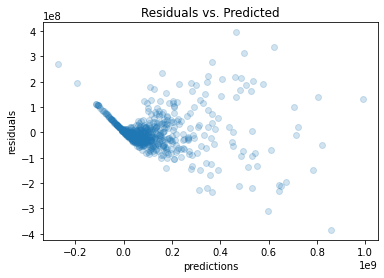

In [43]:
# residuals vs. predicted
y2_predict = lin_reg2.predict(X2)
residuals = y2 - y2_predict
plt.scatter(y2_predict, residuals, alpha=0.2)
plt.plot([0, 400], [0, 400])
plt.title("Residuals vs. Predicted")
plt.xlabel("predictions")
plt.ylabel("residuals");
    

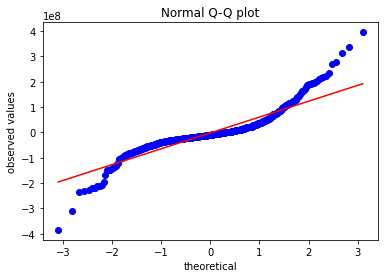

In [44]:
# normal q-q plot
y2_predict = lin_reg2.predict(X2)
residuals = y2 - y2_predict
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.xlabel("theoretical")
plt.ylabel("observed values");
 

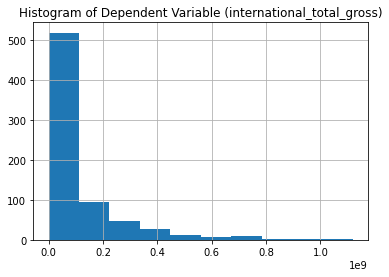

In [45]:
# residuals normally distributed with zero mean
movie_df.international_total_gross.hist(bins=10)
plt.title('Histogram of Dependent Variable (international_total_gross)');

[back to top](#top)

## 7. Best Model<a id='7'></a> 
Fit best model on (train + val), score on test!

[back to top](#top)

## 8. Results<a id='8'></a> 

### 8a. Interpretability<a id='8a'></a> 

In [87]:
# Coefficients, what are the top predictors
lin_reg2 = sm.OLS(y2, X2)
fit2 = lin_reg2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     international_total_gross   R-squared:                       0.817
Model:                                   OLS   Adj. R-squared:                  0.812
Method:                        Least Squares   F-statistic:                     155.9
Date:                       Wed, 23 Mar 2022   Prob (F-statistic):          2.15e-241
Time:                               00:13:46   Log-Likelihood:                -13968.
No. Observations:                        718   AIC:                         2.798e+04
Df Residuals:                            697   BIC:                         2.807e+04
Df Model:                                 20                                         
Covariance Type:                   nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
domestic_total_gross                                0.4300      0.156      2.750      0.006       0.123       0.737
rank                                             8.118e+04   3.31e+04      2.452      0.014    1.62e+04    1.46e+05
max_theaters                                    -1153.7872   1.36e+04     -0.085      0.932   -2.79e+04    2.56e+04
opening_theathers                               -1811.8514    1.1e+04     -0.165      0.869   -2.34e+04    1.98e+04
domestic_opening                                   -1.8807      0.677     -2.776      0.006      -3.211      -0.551
budget                                              0.2301      0.345      0.667      0.505      -0.447       0.907
release_date                                      -15.9773      3.734     -4.279      0.000     -23.308      -8.646
runtime                                          3.429e+05   1.77e+05      1.934      0.053   -5163.571    6.91e+05
rating_PG                                        1.402e+07   2.51e+07      0.558      0.577   -3.53e+07    6.34e+07
rating_PG13                                       1.24e+07   2.54e+07      0.488      0.625   -3.75e+07    6.23e+07
rating_R                                         1.212e+07   2.56e+07      0.473      0.636   -3.82e+07    6.24e+07
distributor_Paramount Pictures                   2.468e+07   1.57e+07      1.570      0.117   -6.19e+06    5.55e+07
distributor_Sony Pictures Entertainment (SPE)    3.204e+07   1.63e+07      1.962      0.050   -1.56e+04    6.41e+07
distributor_Twentieth Century Fox                 3.67e+07   1.56e+07      2.348      0.019    6.01e+06    6.74e+07
distributor_Universal Pictures                   2.064e+07   1.61e+07      1.281      0.201    -1.1e+07    5.23e+07
distributor_Walt Disney Studios Motion Pictures   3.37e+07   1.63e+07      2.071      0.039    1.75e+06    6.56e+07
distributor_Warner Bros.                         3.228e+07   1.51e+07      2.143      0.032     2.7e+06    6.19e+07
distributor_other                                3.042e+07   1.46e+07      2.080      0.038     1.7e+06    5.91e+07
log_international_total_gross                    2.012e+07   2.06e+06      9.759      0.000    1.61e+07    2.42e+07
log_domestic_total_gross                        -7.995e+06   3.33e+06     -2.402      0.017   -1.45e+07   -1.46e+06
profit                                              0.8111      0.156      5.194      0.000       0.504       1.118
opening                                             0.0008      0.000      3.516      0.000       0.000       0.001
opening_minus_budget                               -0.8833      0.441     -2.004      0.045      -1.749   

### 8b. Predictions<a id='8b'></a> 

In [ ]:
# Make a prediction for a new value, does it make sense?

Slides, article, and code available at: https://github.com/slp22/regression-project

[back top top](#top)